In [ ]:
%load_ext autoreload
%autoreload 2

**Ritajit Majumdar**  
Enabling Technologies Researcher @ IBM Quantum  
majumdar.ritajit@ibm.com

**Pedro Rivero**  
Technical Lead @ IBM Quantum  
pedro.rivero@ibm.com

# Understanding ZNE on hardware

In this notebook we shall take a circuit of interest, vary its number of qubits and depth, and apply ZNE mitigation on it. The aim of this exercise is to get a feel for the extrapolator which gives the best result as the number of qubits and depth vary.

For this study we shall use a circuit which is a 1D chain. This ensures that the circuit can be easily mapped on the hardware coupling map with little to no swap gates. However, note that this exercise can be repeated for any other circuit which may not be hardware efficient as well. Moreover, we shall use a compute-uncompute version of the circuit. In this, the circuit unitary $U$ is followed by $U^{\dagger}$ so that the ideal noiseless outcome is $|0\rangle^{\otimes n}$ for an $n$-qubit circuit.

The advantage of such a circuit is that the ideal expectation values for $Z$ type observables are known without explicit simulation which is not possible for utility-scale circuits. The disadvantage is that having an uncompute unitary doubles the depth of the base circuit.

## Qiskit Pattern

### Step 1: Map problem to quantum hardware native format.

#### Logical circuit

We start by declaring an example circuit. Feel free to change it to something else.

In [ ]:
from numpy import pi
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

class ExampleCircuit(QuantumCircuit):
    """Parameterized MBL non-periodic chain (i.e. 1D) quantum circuit.

    Parameters correspond to interaction strength (θ), and
    disorders vector (φ) with one entry per qubit. In 1D,
    θ < 0.16π ≈ 0.5 corresponds to the MBL regime; beyond such
    critical value the dynamics become ergodic (i.e. thermal).
    Disorders are random on a qubit by qubit basis [1].
    
    Args:
        num_qubits: number of qubits (must be even).
        depth: two-qubit depth.
        barriers: if True adds barriers between layers

    Notes:
        [1] Shtanko et.al. Uncovering Local Integrability in Quantum
            Many-Body Dynamics, https://arxiv.org/abs/2307.07552
    """

    def __init__(self, num_qubits: int, depth: int, *, barriers: bool = False) -> None:
        super().__init__(num_qubits)

        theta = Parameter("θ")
        phis = ParameterVector("φ", num_qubits)
        
        self.x(range(1, num_qubits, 2))
        for layer in range(depth):
            layer_parity = layer % 2
            if barriers and layer > 0:
                self.barrier()
            for qubit in range(layer_parity, num_qubits - 1, 2):
                self.cz(qubit, qubit + 1)
                self.u(theta, 0, pi, qubit)
                self.u(theta, 0, pi, qubit + 1)
            for qubit in range(num_qubits):
                self.p(phis[qubit], qubit)

We use a small 8-qubit, depth-4 circuit as our first example. In order to have a deterministic outcome to check against, we build a _compute-uncompute_ (i.e. mirror) version of this circuit. Notice that the base depth will double due to this construct. Since the ideal outcome does not change with the value of the parameters, we can assign them randomly.

In [ ]:
from numpy import pi
from numpy.random import default_rng

# Base circuit
NUM_QUBITS = 8
DEPTH = 4
logical_circuit = ExampleCircuit(NUM_QUBITS, DEPTH // 2)  # Halved depth

# Compute-uncompute construct (doubles the depth)
inverse = logical_circuit.inverse()
logical_circuit.barrier()
logical_circuit.compose(inverse, inplace=True)

# Parameter values
rng = default_rng(seed=0)
parameter_values = rng.uniform(-pi, pi, size=logical_circuit.num_parameters)
parameter_values[0] = 0.3  # Fix interaction strength (specific to MBL circuit)
logical_circuit.assign_parameters(parameter_values, inplace=True)

logical_circuit.draw(output='mpl', fold=-1)

#### Logical observable

Let us select the average of all weight-1 Pauli-Z observables for this example. Note that by nature of the compute-uncompute circuit the ideal value is exactly 1.

In [ ]:
from qiskit.quantum_info import SparsePauliOp

paulis = ['I'*i + 'Z' + 'I'*(NUM_QUBITS-i-1) for i in range(NUM_QUBITS)]
coeffs = 1/len(paulis)

logical_observable = SparsePauliOp(paulis, coeffs)
print(logical_observable)

### Step 2: Optimize circuit and observable

After building the logical circuit and observable we need to optimize them for physical execution on a specific backend.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

try:
    service = QiskitRuntimeService()
except:
    print("Use the token from IBM Industry session and save the account")
    service = QiskitRuntimeService(channel="ibm_quantum", token="4463e0fe7fb2e7d70ba9dfe7eebe7ffc7ef8bf2c57cd2c74f40af32e8b063534f46e1e794ee505523a7d5ca10b20a742b0f0b2306a8959f200d0154c91a36a6c")  # Credentials may be needed
    service.save_account(channel="ibm_quantum", token="4463e0fe7fb2e7d70ba9dfe7eebe7ffc7ef8bf2c57cd2c74f40af32e8b063534f46e1e794ee505523a7d5ca10b20a742b0f0b2306a8959f200d0154c91a36a6c", name="ibm_industry_session", overwrite=True)
    print(f"{[key for key, value in service.saved_accounts().items()]} account saved")

In [ ]:
print(service.backends(simulator=False))
lb = service.least_busy(simulator=False)
print(lb)
backend = service.get_backend(name=lb.name)

#### Physical circuit (transpilation)

In order to execute the logical circuit on actual hardware we need to express it in terms of the hardware's native gates (i.e. Instruction Set Architecture, ISA), as well as assign physical qubits for execution. This action is carried out through the process of _circuit transpilation_.

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
physical_circuit = pm.run(logical_circuit)

physical_circuit.draw(output='mpl', fold=-1, idle_wires=False)

#### Physical observable (layout)

In the same way that we needed to adapt our logical circuit to the hardware, we will need to adapt the associated logical observable in an equivalent way. The resulting physical observable will need to account for the additional qubits in the hardware, as well as for any routing that the logical qubits may have experienced when mapped on to physical ones. This can be easily done by applying the physical circuit's layout to the logical observable. We refer to this process as _observable layout_.

In [ ]:
physical_layout = physical_circuit.layout
physical_observable = logical_observable.apply_layout(physical_layout)

print(physical_observable)

### Step 3: Execute using Qiskit Primitives

Since the goal of this notebook is to understand the effect of extrapolators, we shall repeat the execution multiple times by varying the extrapolator.

In [ ]:
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()

options.default_shots = 4096
options.optimization_level = 0  # Deactivate error suppression
options.resilience_level = 0  # Deactivate error mitigation
options.resilience.zne_mitigation = True  # Activate ZNE error mitigation only

In [ ]:
from qiskit_ibm_runtime import Batch, EstimatorV2

jobs = {}
with Batch(backend=backend) as batch:
    estimator = EstimatorV2(session=batch, options=options)
    pub = (physical_circuit, physical_observable)

    # Linear extrapolation
    extrapolator = 'linear'
    estimator.options.resilience.zne.extrapolator = extrapolator
    jobs[extrapolator] = estimator.run([pub])

    # Quadratic extrapolation
    extrapolator = 'polynomial_degree_2'
    estimator.options.resilience.zne.extrapolator = extrapolator
    jobs[extrapolator] = estimator.run([pub])

    # Exponential extrapolation
    extrapolator = 'exponential'
    estimator.options.resilience.zne.extrapolator = extrapolator
    jobs[extrapolator] = estimator.run([pub])


print("JOB IDS:")
for extrapolator, job in jobs.items():
    print(f"  - {job.job_id()} ({extrapolator})")

### Step 4: Postprocess

Let us observe the mitigated outcomes obtained from different extrapolators

In [ ]:
results = {extrapolator: job.result()[0] for extrapolator, job in jobs.items()}
evs = {extrapolator: result.data.evs.tolist() for extrapolator, result in results.items()}

print("EXPECTATION VALUES:")
for extrapolator, ev in evs.items():
    print(f"  - {ev} ({extrapolator})")

In [ ]:
import json
jb = []
for extrapolator, job_batch in jobs.items():
    dict_batch = {"job_id":job_batch.job_id(), "extrapolator": extrapolator}
    jb.append(dict_batch)
jobs_batches = [{"n_qubits": NUM_QUBITS, "depth": DEPTH, "batch": jb}]
print(jobs_batches)
with open('jobs.json', 'w') as json_file:
    json.dump(jobs_batches, json_file, indent=4)

In [ ]:
def retrieve_job_id(n_qubits, depth, extrapolation_method):
    with open('jobs.json', 'r') as json_file:
        jobs = json.load(json_file)
        for job in jobs:
            print(job)
            if job['n_qubits'] == n_qubits and job['depth'] == depth:
                for c_dict in job['batch']:
                    if c_dict['extrapolator'] == extrapolation_method:
                        return c_dict['job_id']
                    
job_id = retrieve_job_id(n_qubits=NUM_QUBITS, depth=DEPTH, extrapolation_method='linear')



In [ ]:
job = service.job(job_id=job_id)
result = job.result()[0]
ev = result.data.evs.tolist()
print(f"- {ev} (linear)")

## Practice

### Challenge 1

In the following figure, we created a heatmap of the relative error for varying number of qubits and 2-qubit depth without applying ZNE. Note that, in each case, the ideal expectation value is 1.
1. For each extrapolator, create a similar heatmap applying ZNE as shown above.
2. For each entry identify the extrapolator which provides the minimum relative error. In case of tie (up to a threshold), favor the simplest one: `linear` > `polynomial_degree_2` > `exponential`.

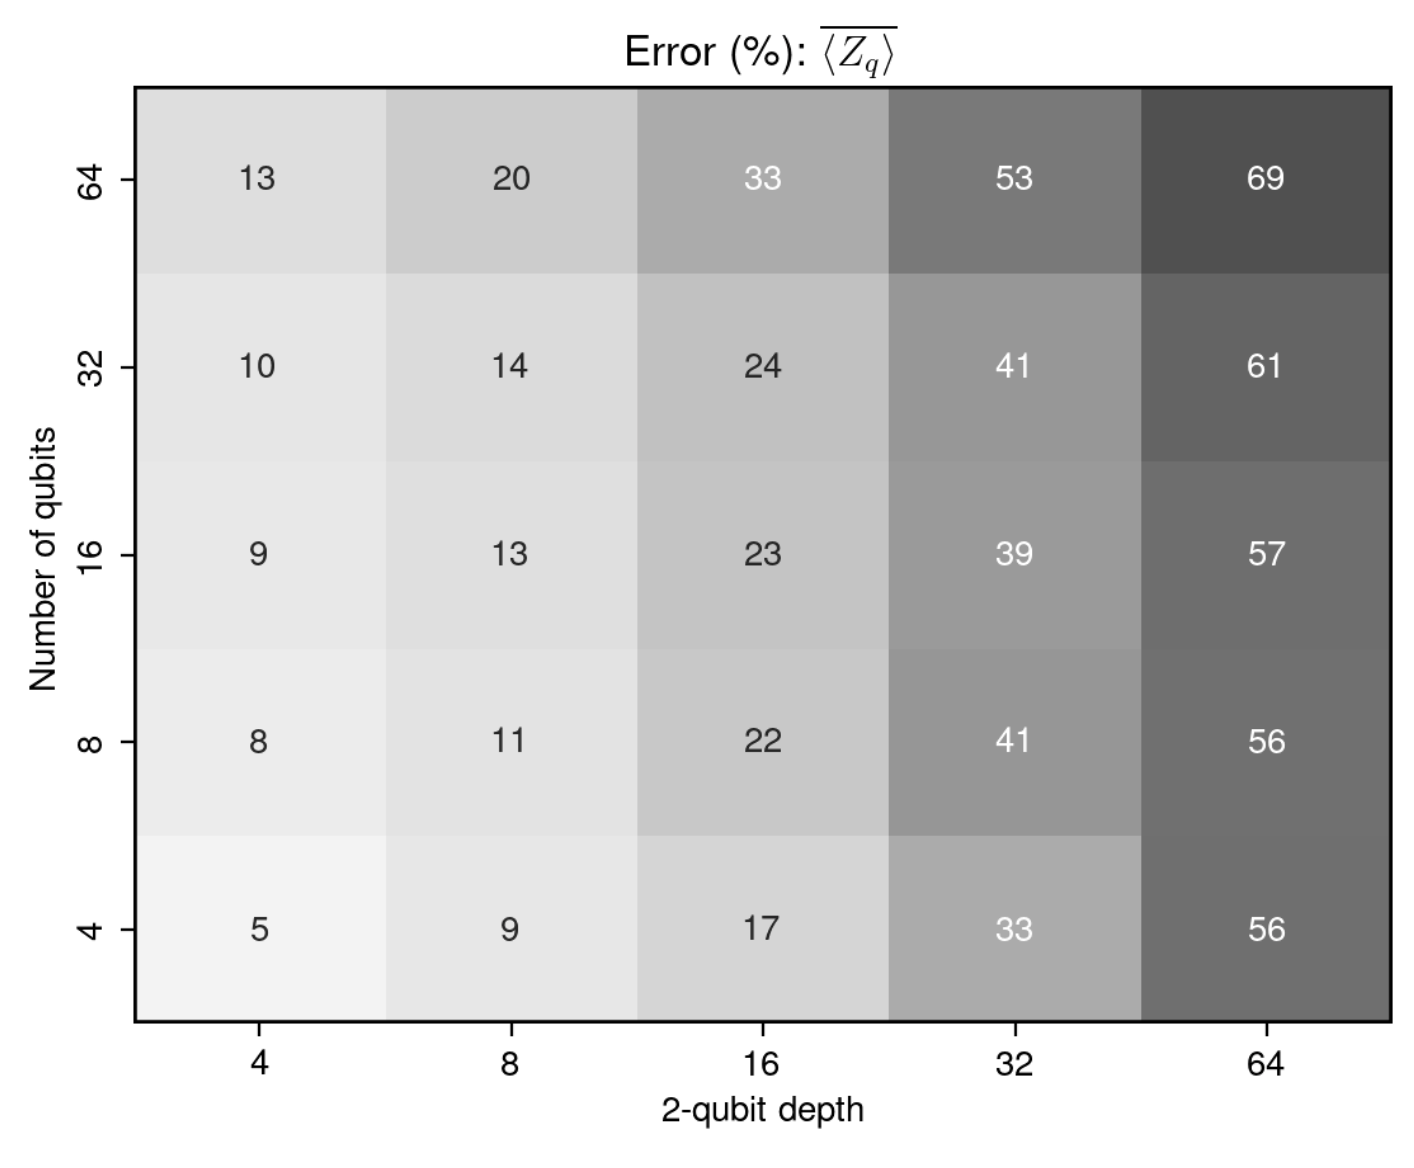

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Generate some random data (replace this with your actual data)
data = np.random.rand(5, 5)

plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='Greys', interpolation='nearest')

# Add title and labels
plt.title('Heatmap of Relative Values')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')

# Show color bar to indicate the values
plt.colorbar()

# Add text annotations
colormap = plt.cm.get_cmap("Greys")
colormap_values = np.linspace(0, 1, 100)
colors = [colormap(value) for value in colormap_values]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i,j] > 0.35 and data[i,j] < 0.65:
            color="black"
        else:
            color=colors[int(100-100*data[i, j])]
        plt.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color=color)

plt.show()

### Challenge 2

In the previous example we used the average of weight-1 Pauli-Z observables as our target observable. Repeat the same exercise for the average of (logically) adjacent weight-2 Pauli-Z observables (i.e. `ZZIII...`, `IZZII...`, `IIZZI...`, ...). Questions:
1. How does the quality of the results compare to the previous example?
2. Does the best extrapolator in each case change with the weight of the operator?

### Challenge 3

In the previous two challenges, measurement error mitigation was turned off. Turn on measurement error mitigation by setting `estimator.options.resilience.measure_mitigation = True`. Create the heatmap, now with both measurement error mitigation and ZNE enabled.
1. How does the relative error change when measurement error mitigation is applied? 
2. How does the best extrapolator change?